In [1]:
#Importing all necessary modules

from collections import OrderedDict

import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

from torch import nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

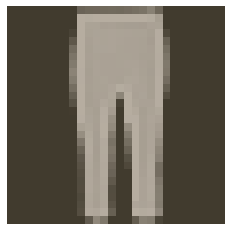

In [4]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

# Model 1 - ANN

In [5]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [400, 200, 100]
output_size  = 10
model = nn.Sequential(OrderedDict([
          ('h1',   nn.Linear(input_size, hidden_sizes[0])),
          ('rel1', nn.ReLU()),
          ('h2',   nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('rel2', nn.ReLU()),
          ('h3',   nn.Linear(hidden_sizes[1], hidden_sizes[2])),
          ('rel3', nn.ReLU()),
          ('output', nn.Linear(hidden_sizes[2], output_size)), 
          ('softmax', nn.Softmax(dim=1))]))

model

Sequential(
  (h1): Linear(in_features=784, out_features=400, bias=True)
  (rel1): ReLU()
  (h2): Linear(in_features=400, out_features=200, bias=True)
  (rel2): ReLU()
  (h3): Linear(in_features=200, out_features=100, bias=True)
  (rel3): ReLU()
  (output): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

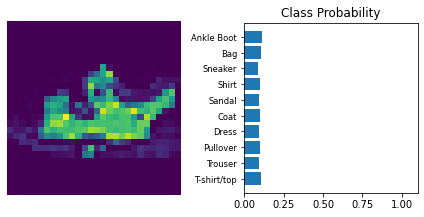

In [6]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[9].view(1, 28, 28), ps, version='Fashion')

In [7]:
epochs = 5
print_every = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07)

correct = 0
total = 0 

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
    
    with torch.no_grad():
        for data in testloader:
            output = model.forward(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy:',round((100*correct/total),2))

Epoch: 1/5
	Iteration: 0	 Loss: 0.0576
	Iteration: 40	 Loss: 2.3019
	Iteration: 80	 Loss: 2.2998
	Iteration: 120	 Loss: 2.2971
	Iteration: 160	 Loss: 2.2934
	Iteration: 200	 Loss: 2.2867
	Iteration: 240	 Loss: 2.2739
	Iteration: 280	 Loss: 2.2424
	Iteration: 320	 Loss: 2.1737
	Iteration: 360	 Loss: 2.0943
	Iteration: 400	 Loss: 2.0334
	Iteration: 440	 Loss: 1.9565
	Iteration: 480	 Loss: 1.8997
	Iteration: 520	 Loss: 1.8409
	Iteration: 560	 Loss: 1.7945
	Iteration: 600	 Loss: 1.7799
	Iteration: 640	 Loss: 1.7700
	Iteration: 680	 Loss: 1.7509
	Iteration: 720	 Loss: 1.7457
	Iteration: 760	 Loss: 1.7181
	Iteration: 800	 Loss: 1.7232
	Iteration: 840	 Loss: 1.7189
	Iteration: 880	 Loss: 1.7082
	Iteration: 920	 Loss: 1.7209
Accuracy: 71.88
Epoch: 2/5
	Iteration: 0	 Loss: 0.0450
	Iteration: 40	 Loss: 1.7079
	Iteration: 80	 Loss: 1.7022
	Iteration: 120	 Loss: 1.7058
	Iteration: 160	 Loss: 1.6990
	Iteration: 200	 Loss: 1.7134
	Iteration: 240	 Loss: 1.6935
	Iteration: 280	 Loss: 1.6964
	Iteration

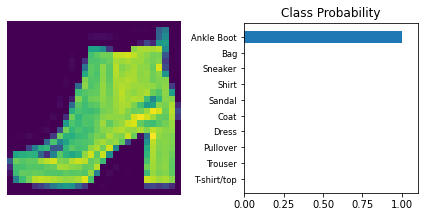

In [8]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps, version='Fashion')

 # Model 2 - CNN

In [44]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    t = F.softmax(t) 
    # don't need softmax here since we'll use cross-entropy as activation.

    return t
model = Network()
model 

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

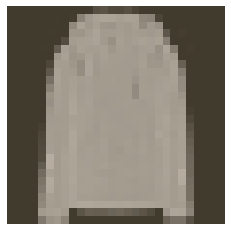

In [45]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [81]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10),
            nn.Softmax(dim=1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
model = Net()
model

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

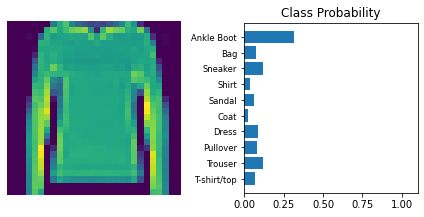

In [82]:
 images, labels = next(iter(testloader))
#images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0:2])
view_classify(images[0].view(1, 28, 28), ps[0], version='Fashion')

In [85]:
epochs = 10
print_every = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007)

correct = 0
total = 0 

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        #images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
    
    with torch.no_grad():
        for data in testloader:
            output = model.forward(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy:',round((100*correct/total),2))

Epoch: 1/10
	Iteration: 0	 Loss: 0.0453
	Iteration: 40	 Loss: 1.7541
	Iteration: 80	 Loss: 1.7439
	Iteration: 120	 Loss: 1.7428
	Iteration: 160	 Loss: 1.7452
	Iteration: 200	 Loss: 1.7343
	Iteration: 240	 Loss: 1.7243
	Iteration: 280	 Loss: 1.7332
	Iteration: 320	 Loss: 1.7336
	Iteration: 360	 Loss: 1.7344
	Iteration: 400	 Loss: 1.7279
	Iteration: 440	 Loss: 1.7391
	Iteration: 480	 Loss: 1.7338
	Iteration: 520	 Loss: 1.7420
	Iteration: 560	 Loss: 1.7368
	Iteration: 600	 Loss: 1.7289
	Iteration: 640	 Loss: 1.7319
	Iteration: 680	 Loss: 1.7360
	Iteration: 720	 Loss: 1.7297
	Iteration: 760	 Loss: 1.7412
	Iteration: 800	 Loss: 1.7436
	Iteration: 840	 Loss: 1.7520
	Iteration: 880	 Loss: 1.7318
	Iteration: 920	 Loss: 1.7395
Accuracy: 62.5
Epoch: 2/10
	Iteration: 0	 Loss: 0.0436
	Iteration: 40	 Loss: 1.7426
	Iteration: 80	 Loss: 1.7316
	Iteration: 120	 Loss: 1.7349
	Iteration: 160	 Loss: 1.7380
	Iteration: 200	 Loss: 1.7281
	Iteration: 240	 Loss: 1.7179
	Iteration: 280	 Loss: 1.7287
	Iteratio

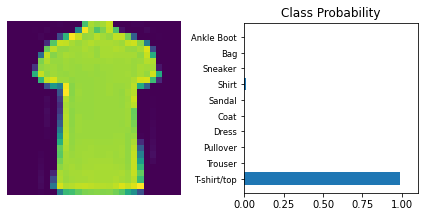

In [88]:
images, labels = next(iter(testloader))
#images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0:2])
view_classify(images[0].view(1, 28, 28), ps[0], version='Fashion')

# Model 3 - CNN(AlexNet)

In [72]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t
model = Network()
model 

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [73]:
import torchvision
import torchvision.transforms as transforms

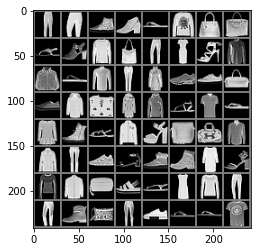

In [74]:
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(ax2.yticklabels)

In [75]:
#import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [76]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [77]:
AlexNet_model.features[0] = nn.Conv2d(1, 64, kernel_size=4)
AlexNet_model.classifier[4] = nn.Linear(4096,1024)
AlexNet_model.classifier[6] = nn.Linear(1024,10)

In [78]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

In [79]:
import torch.optim as optim
import torch.nn as nn

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [80]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

KeyboardInterrupt: ignored

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a1edc71-d367-444d-a290-6ccbe6d94df7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>